# AT&T Spam Detector - TFBertForSequenceClassification - bert-base-uncased

* This code use bert-base-uncased (cat = CAT )

In [1]:
# conda create --name tf_cpu_bert_seq --file ./assets/requirements_tf_cpu_bert_seq_model.txt

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import unicodedata

import re
import en_core_web_sm # conda install spacy-model-en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS



from pathlib import Path
k_Current_dir = Path.cwd()
k_AssetsDir = "assets"
k_sms_max_len   = 100
k_random_state  = 42
k_batch_size    = 64
k_test_size     = 0.3
k_epochs        = 2



c:\Users\phili\anaconda3\envs\tf_cpu_bert_seq\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------------------------------------------------------
# drop empty cols and duplicates, rename cols...
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "labels"}, inplace=True)
    df.rename(columns={"v2": "texts"}, inplace=True)

    df["labels"] = df["labels"].map({"ham": 0, "spam": 1})

    # Remove punctuation  
    df["texts"] = df["texts"].apply(lambda x: re.sub("[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+"," ", x)) 

    # see model.save(path) lower
    # https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta
    # remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    # df["texts"] = df["texts"].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x)) 

    # def unicode_to_ascii(s):
    # def unicode_to_ascii(s):
    #     return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    # df["texts"] = df["texts"].apply(lambda x: unicode_to_ascii(x))

    # fillna() makes sure NA is replaced with "" so that lowering case do not generate error
    df["texts"] = df["texts"].fillna("").apply(lambda x: x.lower())

    nlp = en_core_web_sm.load()

    # Tokenize the cleaned document
    df["texts"] = df["texts"].fillna("").apply(lambda x: nlp(x))

    # remove stop-words, replace words with their lemma
    df["texts"] = df["texts"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

    # clean up tokenized documents
    df["texts"] = [" ".join(x) for x in df["texts"]]

    
    display(df.head(20))
    # df.info()
    return df

In [3]:
# Convert data into InputExample
def convert_data_to_examples(texts, labels):
    examples = []
    for text, label in zip(texts, labels):
        examples.append(InputExample(guid=None, text_a=text, text_b=None, label=label))
    return examples


In [4]:
# Convert InputExample into InputFeatures
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=k_sms_max_len):
    features = []

    for example in examples:
        input_dict = tokenizer.encode_plus(
            example.text_a,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )
        input_ids, attention_mask = input_dict["input_ids"], input_dict["attention_mask"]

        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                label=example.label
            )
        )

    def gen():
        for feature in features:
            yield (
                {
                    'input_ids': feature.input_ids,
                    'attention_mask': feature.attention_mask
                },
                feature.label
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({'input_ids': tf.int32, 'attention_mask': tf.int32}, tf.int64),
        ({'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None])}, tf.TensorShape([])),
    )


,labels,texts
0,0,jurong point crazy available bugis n great...
1,0,ok lar joke wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun early hor u c
4,0,nah think go usf live
5,1,freemsg hey darle 3 week word like fun tb ...
6,0,brother like speak treat like aids patent
7,0,request ' melle melle oru minnaminunginte nu...
8,1,winner value network customer select receive...
9,1,mobile 11 month u r entitle update late colo...


c:\Users\phili\anaconda3\envs\tf_cpu_bert_seq\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 24,429,314
Non-trainable params: 85,054,464
_________________________________________________________________


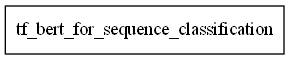

In [5]:
# see scrapbook on how to detect encoding
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
# df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="ISO-8859-1")
# df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="utf-8", encoding_errors="ignore")
df = cleaner(df)

X = df['texts'].values
y = df['labels'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_examples = convert_data_to_examples(X_train, y_train)
test_examples  = convert_data_to_examples(X_test, y_test)

train_dataset = convert_examples_to_tf_dataset(train_examples, tokenizer)
test_dataset  = convert_examples_to_tf_dataset(test_examples, tokenizer)

train_dataset = train_dataset.shuffle(100).batch(k_batch_size).repeat(2)
test_dataset  = test_dataset.batch(k_batch_size)

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# checking 
# for x, y in train_dataset.take(1):
#     print(f'y_true shape: {y.shape}')
#     predictions = model(x)
#     logits = predictions.logits
#     print(f'y_pred shape: {logits.shape}')  


# ! Freeze all layers, included layers form head classification.
# The whole model cannot be trained
# Not a good idea
# for layer in model.layers:

# Freeze only internal layers of BERT. 
# Classification layers can be trained
# Smarter
for layer in model.bert.encoder.layer:
    layer.trainable = False




In [ ]:
# model.summary()

# Get access to BERT model
bert_model = model.bert
bert_model.summary()

# Get access to the "head"
classifier = model.classifier
classifier.summary()

for layer in model.layers:
    print(layer.name, layer.output_shape)

path = Path(f"{k_Current_dir/k_AssetsDir/'bert_seq_uncased_arch.png'}")
tf.keras.utils.plot_model(model, path, show_shapes=True)



In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',           # can be 'val_accuracy' if needed 
    patience=3,          
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,       # reduction factor of learning rate
    patience=2,       
    min_lr=1e-7       # minimal value for learning rate
)

# checkpoint does'nt work because it use model.save() which have issue with utf-8 
# model.save_pretrained() seems to work however
# see Custom callback to be used as a replacement of checkpoints in scrapbook section
# path = Path(f"{k_Current_dir/k_AssetsDir/'bert_seq_uncased_best_model.h5'}")
# path = Path(f"{k_Current_dir/k_AssetsDir}/bert_seq_uncased_saved_model")
# checkpoint = ModelCheckpoint(
#     path,                       # model's path
#     monitor='val_loss', 
#     save_best_only=True, 
#     mode='min',
#     save_format='tf'  # Use TensorFlow format. Does'nt work otherwise
# )

tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)
print(f"\n\n--------------------------------------------------")
print(f"Once the model runs, open a terminal, make sure you are in the directory of the project and type in : ")
print(f"tensorboard --logdir=logs")
print(f"Then visit the URL")




--------------------------------------------------
Once the model runs, open a terminal, make sure you are in the directory of the project and type in : 
tensorboard --logdir=logs
Then visit the URL


In [7]:
# 00H20/epoch & 228 steps when k_batch_size=32
# 00H15/epoch & 114 steps when k_batch_size=64

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# ! Does'nt work yet. 
# ! I DO NOT UNDERSTAND
# metrics=[
#     tf.keras.metrics.SparseCategoricalAccuracy('accuracy'), # order of metrics matters ?
#     tf.keras.metrics.Recall(name="recall"), 
#     tf.keras.metrics.Precision(name="precision"), 
# ]   # name=... avoid recall_1 for example

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(
    train_dataset, 
    epochs=k_epochs, 
    validation_data=test_dataset,
    # checkpoint does'nt work
    # see Custom callback to be used as a replacement of checkpoints in scrapbook section
    # callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard]
    callbacks=[early_stopping, reduce_lr, tensorboard]
)


Epoch 1/2
114/114 [==============================] - 1182s 10s/step - loss: 0.3077 - accuracy: 0.8954 - val_loss: 0.1458 - val_accuracy: 0.9703 - lr: 3.0000e-05
Epoch 2/2
114/114 [==============================] - 1257s 11s/step - loss: 0.0853 - accuracy: 0.9807 - val_loss: 0.0623 - val_accuracy: 0.9832 - lr: 3.0000e-05


In [8]:
# You can but do NOT use h5 as file format to save the model
# model.save('path_to_save_model/model.h5', save_format='h5')

# I had an issue with utf-8 0x92 : UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 315: invalid start byte
# 0x92 is a smart quote(’) of Windows-1252. It simply doesn't exist in unicode, therefore it can't be decoded
# https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta
# I added more steps in cleaner() (see above) but it did'nt help
# The solution => use model.save_pretrained() rather than model.save()
# The line below is better than using h5 but it is useless IF in ModelCheckpoint() "save_best_only" is set to "True" (which is NOT the case in this code)
path = Path(f"{k_Current_dir/k_AssetsDir}/bert_seq_uncased_saved_model")
model.save_pretrained(path)
# model.save(path)

# If you need to load a model saved with model.save_pretrained()
# from transformers import TFBertForSequenceClassification
# model = TFBertForSequenceClassification.from_pretrained(path)

# If you need to load a model saved with model.save() 
# model = tf.keras.models.load_model(path)


In [9]:
# -----------------------------------------------------------------------------
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

Saving figure bert_seq_uncased_loss


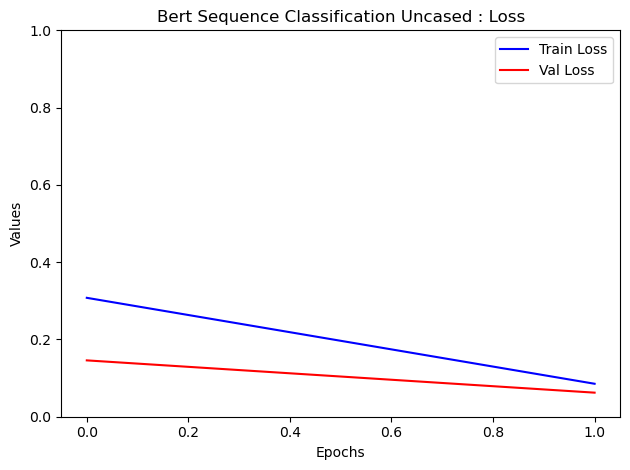

[[0.307717, 0.085297]]

[[0.145819, 0.062274]]

In [10]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert Sequence Classification Uncased : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("bert_seq_uncased_loss", "png")
plt.show()

display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


Saving figure bert_seq_uncased_accuracy


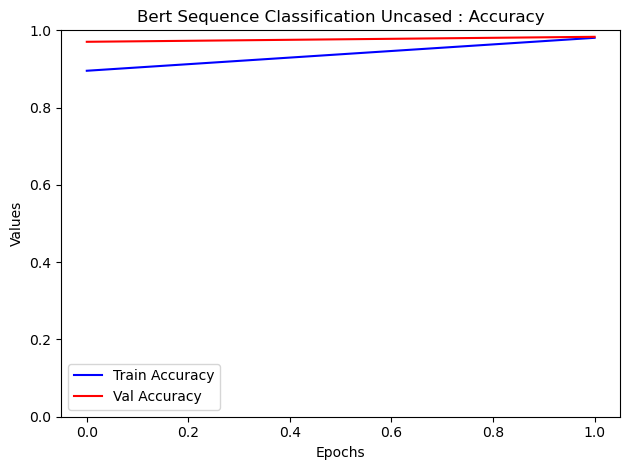

[[0.895384, 0.980652]]

[[0.970342, 0.983237]]

In [11]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Bert Sequence Classification Uncased : Accuracy")
plt.legend()
plt.ylim(0,1)
save_fig("bert_seq_uncased_accuracy", "png")
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


In [12]:
# plt.plot(history.history["precision"], color="b", label="Train Precision")
# plt.plot(history.history["val_precision"], color="r", label="Val Precision")
# plt.ylabel("Values")
# plt.xlabel("Epochs")
# plt.title("Bert Sequence Classification Uncased : Precision")
# plt.legend()
# plt.ylim(0,1)
# save_fig("bert_seq_uncased_precision", "png")
# plt.show()

# display([[round(f, 6) for f in history.history['precision'][-10:]]])
# display([[round(f, 6) for f in history.history['val_precision'][-10:]]])

In [13]:
# plt.plot(history.history["recall"], color="b", label="Train Recall")
# plt.plot(history.history["val_recall"], color="r", label="Val Recall")
# plt.ylabel("Values")
# plt.xlabel("Epochs")
# plt.title("Bert Sequence Classification Uncased : Recall")
# plt.legend()
# plt.ylim(0,1)
# save_fig("bert_seq_uncased_recall", "png")
# plt.show()

# display([[round(f, 6) for f in history.history['recall'][-10:]]])
# display([[round(f, 6) for f in history.history['val_recall'][-10:]]])

In [14]:
# def f1_calculus(name, rec, prec):
#     df_tmp=pd.DataFrame()
#     df_tmp[name] = 2*np.array(rec)*np.array(prec)/(np.array(rec)+np.array(prec)+tf.keras.backend.epsilon()) # epsilon avoid runtimeWarning: divide by zero encountered in divide...
#     return df_tmp

In [15]:
# df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
# df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

# plt.plot(df_tmp["f1"], color="b", label="Train F1")
# plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
# plt.ylabel("Values")
# plt.xlabel("Epochs")
# plt.title("Bert Sequence Classification Uncased : F1")
# plt.legend()
# plt.ylim(0,1)
# save_fig("bert_seq_uncased_f1", "png")
# plt.show()

# display(df_tmp.tail(10))
# display(df_val_tmp.tail(10))

# <span style="color:red"><b>Scrapbook - Please ignore</b></span>

In [16]:
import unicodedata
import pandas as pd

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

df = pd.DataFrame({
    'texts': ['élève', 'café', 'mañana', 'français']
})
display(df)

df["texts"] = df["texts"].apply(lambda x: unicode_to_ascii(x))
display(df)


,texts
0,élève
1,café
2,mañana
3,français


,texts
0,eleve
1,cafe
2,manana
3,francais


In [17]:
# Windows cp1252
# Linux, Web : ISO-8859-1, UTF-8
import chardet

with open(k_Current_dir/k_AssetsDir/"spam.csv", "rb") as file:
    raw_data = file.read(10000)  # read 10_000 bytes

result = chardet.detect(raw_data)
encoding = result['encoding']

print(f"Encoding = {encoding}")

# Lire le fichier avec l'encodage détecté
df = pd.read_csv(k_Current_dir/k_AssetsDir/"spam.csv", encoding=encoding)


# One can try
df = pd.read_csv(k_Current_dir/k_AssetsDir/"spam.csv", encoding="utf-8", encoding_errors="ignore")

Encoding = Windows-1252


In [18]:
# Checking path
# path = Path(f"{k_Current_dir/k_AssetsDir}/bert_seq_uncased_saved_model")
# print(path)

df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

path = Path(f"{k_Current_dir/k_AssetsDir}/bert_seq_uncased_saved_model")
model.save_pretrained(path)
# model.save(path)



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Custom callback to be used as a replacement of checkpoints

import tensorflow as tf
from transformers import TFBertForSequenceClassification

class SavePretrainedCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_path, monitor='val_loss', mode='min', save_best_only=True):
        super(SavePretrainedCheckpoint, self).__init__()
        self.save_path = save_path
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.best = None

        # Mode min or max, min -> we save when val_loss decreases, max -> when a metric increases
        if self.mode == 'min':
            self.monitor_op = lambda current, best: current < best
            self.best = float('inf')
        else:
            self.monitor_op = lambda current, best: current > best
            self.best = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)

        if current is None:
            print(f"Warning: Metric {self.monitor} is not available. Skipping save.")
            return

        if not self.save_best_only or self.monitor_op(current, self.best):
            print(f"Saving model to {self.save_path} at epoch {epoch + 1}")
            self.best = current
            # Use save_pretrained to save the model
            self.model.save_pretrained(self.save_path)

# Use SavePretrainedCheckpoint during model.fit()
save_path = "path/to/save/model"
save_pretrained_callback = SavePretrainedCheckpoint(save_path, monitor='val_loss', mode='min', save_best_only=True)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[save_pretrained_callback]
)

NameError: name 'val_dataset' is not defined